In [2]:
import pandas as pd
import numpy as np

#seaborn이나 matplotlib 사용하기
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

import time

#sklearn 라이브러리를 사용하기
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import class_weight

%matplotlib inline
import matplotlib.gridspec as GridSpec

#pywt와  scipy라이브러리 사용하기
import pywt
from scipy import fftpack
from scipy import signal
from scipy import optimize
import itertools

In [3]:
dir_path = '/Users/jinchan/edjjincode/NiseLabProject/Data/'

In [4]:
#데이터 셋 불러오기(train 데이터, test 데이터, rul 데이터)
def prepare_data(dir_path):
    dependent_var = ['RUL']
    index_columns_names =  ["UnitNumber","Cycle"]
    operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
    sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
    input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

    df_train = pd.read_csv(dir_path + 'train_FD001.txt',delim_whitespace=True,names=input_file_column_names)

    rul = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
    rul.columns = ['UnitNumber', 'max']
    df_train = df_train.merge(rul, on=['UnitNumber'], how='left')
    df_train['RUL'] = df_train['max'] - df_train['Cycle']
    df_train.drop('max', axis=1, inplace=True)

    df_test = pd.read_csv(dir_path + 'test_FD001.txt', delim_whitespace=True, names=input_file_column_names)

    y_true = pd.read_csv(dir_path + 'RUL_FD001.txt', delim_whitespace=True,names=["RUL"])
    y_true["UnitNumber"] = y_true.index + 1

    return df_train, df_test, y_true

In [5]:
df_train, df_test, y_true = prepare_data(dir_path)
df_train.shape, df_test.shape, y_true.shape

((20631, 27), (13096, 26), (100, 2))

In [6]:
df_train.head()

UnitNumber  Cycle  OpSet1  OpSet2  OpSet3  SensorMeasure1  SensorMeasure2  \
0           1      1 -0.0007 -0.0004   100.0          518.67          641.82   
1           1      2  0.0019 -0.0003   100.0          518.67          642.15   
2           1      3 -0.0043  0.0003   100.0          518.67          642.35   
3           1      4  0.0007  0.0000   100.0          518.67          642.35   
4           1      5 -0.0019 -0.0002   100.0          518.67          642.37   

   SensorMeasure3  SensorMeasure4  SensorMeasure5  ...  SensorMeasure13  \
0         1589.70         1400.60           14.62  ...          2388.02   
1         1591.82         1403.14           14.62  ...          2388.07   
2         1587.99         1404.20           14.62  ...          2388.03   
3         1582.79         1401.87           14.62  ...          2388.08   
4         1582.85         1406.22           14.62  ...          2388.04   

   SensorMeasure14  SensorMeasure15  SensorMeasure16  SensorMeasure17  \
0          8138.62           8.4195             0.03              392   
1          8131.49           8.4318             0.03              392   
2          8133.23           8.4178             0.03              390   
3          8133.83           8.3682             0.03              392   
4          8133.80           8.4294             0.03              393   

   SensorMeasure18  SensorMeasure19  SensorMeasure20  SensorMeasure21  RUL  
0             2388            100.0            39.06          23.4190  191  
1             2388            100.0            39.00          23.4236  190  
2             2388            100.0            38.95          23.3442  189  
3             2388            100.0            38.88          23.3739  188  
4             2388            100.0            38.90          23.4044  187  

[5 rows x 27 columns]

In [7]:
index_names = ['UnitNumber', 'Cycle']
df_train[index_names].describe()

UnitNumber         Cycle
count  20631.000000  20631.000000
mean      51.506568    108.807862
std       29.227633     68.880990
min        1.000000      1.000000
25%       26.000000     52.000000
50%       52.000000    104.000000
75%       77.000000    156.000000
max      100.000000    362.000000

In [8]:
df_train[index_names].groupby("UnitNumber").max().describe()

Cycle
count  100.000000
mean   206.310000
std     46.342749
min    128.000000
25%    177.000000
50%    199.000000
75%    229.250000
max    362.000000

In [9]:
sensor_cols = [f"SensorMeasure{i}" for i in range(1, 22)]

In [10]:
df_train[sensor_cols].describe().transpose()

count         mean           std        min        25%  \
SensorMeasure1   20631.0   518.670000  6.537152e-11   518.6700   518.6700   
SensorMeasure2   20631.0   642.680934  5.000533e-01   641.2100   642.3250   
SensorMeasure3   20631.0  1590.523119  6.131150e+00  1571.0400  1586.2600   
SensorMeasure4   20631.0  1408.933782  9.000605e+00  1382.2500  1402.3600   
SensorMeasure5   20631.0    14.620000  3.394700e-12    14.6200    14.6200   
SensorMeasure6   20631.0    21.609803  1.388985e-03    21.6000    21.6100   
SensorMeasure7   20631.0   553.367711  8.850923e-01   549.8500   552.8100   
SensorMeasure8   20631.0  2388.096652  7.098548e-02  2387.9000  2388.0500   
SensorMeasure9   20631.0  9065.242941  2.208288e+01  9021.7300  9053.1000   
SensorMeasure10  20631.0     1.300000  4.660829e-13     1.3000     1.3000   
SensorMeasure11  20631.0    47.541168  2.670874e-01    46.8500    47.3500   
SensorMeasure12  20631.0   521.413470  7.375534e-01   518.6900   520.9600   
SensorMeasure13  20631.0  2388.096152  7.191892e-02  2387.8800  2388.0400   
SensorMeasure14  20631.0  8143.752722  1.907618e+01  8099.9400  8133.2450   
SensorMeasure15  20631.0     8.442146  3.750504e-02     8.3249     8.4149   
SensorMeasure16  20631.0     0.030000  1.556432e-14     0.0300     0.0300   
SensorMeasure17  20631.0   393.210654  1.548763e+00   388.0000   392.0000   
SensorMeasure18  20631.0  2388.000000  0.000000e+00  2388.0000  2388.0000   
SensorMeasure19  20631.0   100.000000  0.000000e+00   100.0000   100.0000   
SensorMeasure20  20631.0    38.816271  1.807464e-01    38.1400    38.7000   
SensorMeasure21  20631.0    23.289705  1.082509e-01    22.8942    23.2218   

                       50%        75%        max  
SensorMeasure1    518.6700   518.6700   518.6700  
SensorMeasure2    642.6400   643.0000   644.5300  
SensorMeasure3   1590.1000  1594.3800  1616.9100  
SensorMeasure4   1408.0400  1414.5550  1441.4900  
SensorMeasure5     14.6200    14.6200    14.6200  
SensorMeasure6     21.6100    21.6100    21.6100  
SensorMeasure7    553.4400   554.0100   556.0600  
SensorMeasure8   2388.0900  2388.1400  2388.5600  
SensorMeasure9   9060.6600  9069.4200  9244.5900  
SensorMeasure10     1.3000     1.3000     1.3000  
SensorMeasure11    47.5100    47.7000    48.5300  
SensorMeasure12   521.4800   521.9500   523.3800  
SensorMeasure13  2388.0900  2388.1400  2388.5600  
SensorMeasure14  8140.5400  8148.3100  8293.7200  
SensorMeasure15     8.4389     8.4656     8.5848  
SensorMeasure16     0.0300     0.0300     0.0300  
SensorMeasure17   393.0000   394.0000   400.0000  
SensorMeasure18  2388.0000  2388.0000  2388.0000  
SensorMeasure19   100.0000   100.0000   100.0000  
SensorMeasure20    38.8300    38.9500    39.4300  
SensorMeasure21    23.2979    23.3668    23.6184

In [11]:
sc = MinMaxScaler(feature_range=(0,1))
df_train[sensor_cols] = sc.fit_transform(df_train[sensor_cols])
df_test[sensor_cols] = sc.transform(df_test[sensor_cols])

/Users/jinchan/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/jinchan/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

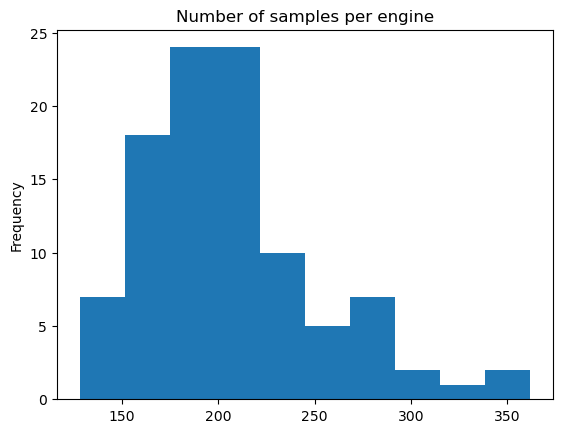

In [12]:
df_train.groupby("UnitNumber").size().plot(kind="hist")
plt.title("Number of samples per engine")
plt.show()

In [13]:
df_sensors = df_train[sensor_cols]

In [14]:
def trendability(col):
    trend_vals = []
    for i in df_train.UnitNumber.unique():
        dff = df_train[df_train.UnitNumber == i]
        trend_vals.append(dff[['Cycle', col]].corr().iloc[0][1])
    return np.abs(np.mean(trend_vals))

In [15]:
trend_df_list = []
for col in sensor_cols:
    trend_df_list.append({'feature': col, 'trendability_val': trendability(col)})
trend_df = pd.DataFrame(trend_df_list, columns = ['feature', 'trendability_val'])

/var/folders/87/g853z5ls20d2k235h1ck1zmr0000gn/T/ipykernel_94387/864880832.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_vals.append(dff[['Cycle', col]].corr().iloc[0][1])
/var/folders/87/g853z5ls20d2k235h1ck1zmr0000gn/T/ipykernel_94387/864880832.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_vals.append(dff[['Cycle', col]].corr().iloc[0][1])
/var/folders/87/g853z5ls20d2k235h1ck1zmr0000gn/T/ipykernel_94387/864880832.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behav

In [16]:
trend_df = trend_df.sort_values(by = 'trendability_val', ascending = False)
trend_df.head()

feature  trendability_val
10  SensorMeasure11          0.810601
11  SensorMeasure12          0.789662
3    SensorMeasure4          0.781614
6    SensorMeasure7          0.761514
14  SensorMeasure15          0.724844

/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='trendability_val', ylabel='feature'>

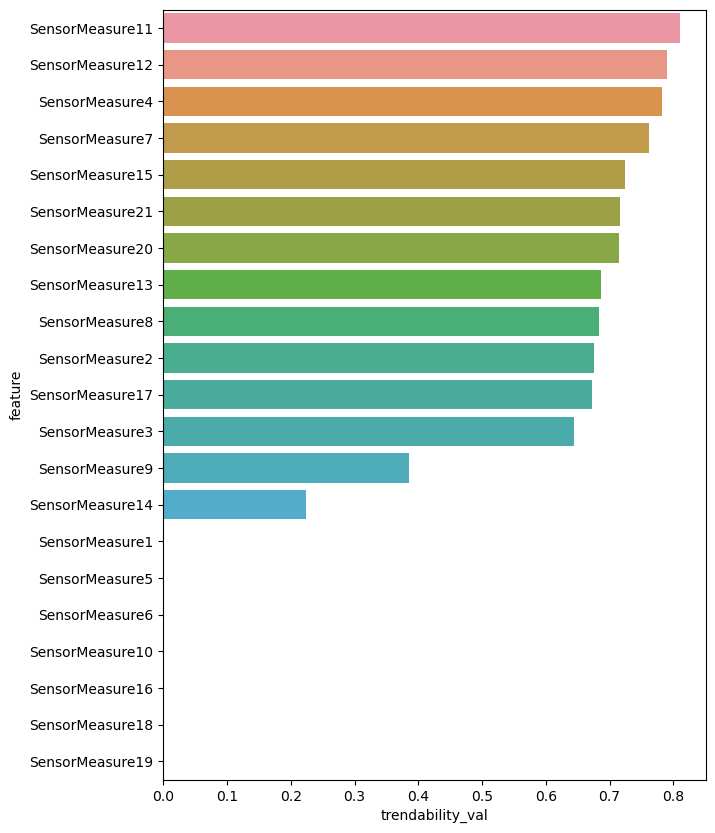

In [17]:
fig, ax = plt.subplots(figsize = (7,10))
sns.barplot(y = trend_df.feature, x = trend_df.trendability_val)

In [18]:
feats = trend_df.feature[trend_df.trendability_val > 0.2]
feats

10    SensorMeasure11
11    SensorMeasure12
3      SensorMeasure4
6      SensorMeasure7
14    SensorMeasure15
20    SensorMeasure21
19    SensorMeasure20
12    SensorMeasure13
7      SensorMeasure8
1      SensorMeasure2
16    SensorMeasure17
2      SensorMeasure3
8      SensorMeasure9
13    SensorMeasure14
Name: feature, dtype: object

In [19]:
df = df_train[feats]

In [20]:
df

SensorMeasure11  SensorMeasure12  SensorMeasure4  SensorMeasure7  \
0             0.369048         0.633262        0.309757        0.726248   
1             0.380952         0.765458        0.352633        0.628019   
2             0.250000         0.795309        0.370527        0.710145   
3             0.166667         0.889126        0.331195        0.740741   
4             0.255952         0.746269        0.404625        0.668277   
...                ...              ...             ...             ...   
20626         0.726190         0.170576        0.782917        0.254428   
20627         0.708333         0.211087        0.866475        0.162641   
20628         0.738095         0.281450        0.775321        0.175523   
20629         0.916667         0.208955        0.747468        0.133655   
20630         0.803571         0.130064        0.842167        0.151369   

       SensorMeasure15  SensorMeasure21  SensorMeasure20  SensorMeasure13  \
0             0.363986         0.724662         0.713178         0.205882   
1             0.411312         0.731014         0.666667         0.279412   
2             0.357445         0.621375         0.627907         0.220588   
3             0.166603         0.662386         0.573643         0.294118   
4             0.402078         0.704502         0.589147         0.235294   
...                ...              ...              ...              ...   
20626         0.656791         0.109500         0.271318         0.558824   
20627         0.727203         0.366197         0.124031         0.500000   
20628         0.922278         0.053991         0.232558         0.529412   
20629         0.823394         0.234466         0.116279         0.514706   
20630         0.687572         0.218172         0.178295         0.558824   

       SensorMeasure8  SensorMeasure2  SensorMeasure17  SensorMeasure3  \
0            0.242424        0.183735         0.333333        0.406802   
1            0.212121        0.283133         0.333333        0.453019   
2            0.272727        0.343373         0.166667        0.369523   
3            0.318182        0.343373         0.333333        0.256159   
4            0.242424        0.349398         0.416667        0.257467   
...               ...             ...              ...             ...   
20626        0.439394        0.686747         0.750000        0.587312   
20627        0.500000        0.701807         0.583333        0.729453   
20628        0.515152        0.665663         0.833333        0.684979   
20629        0.530303        0.608434         0.583333        0.746021   
20630        0.545455        0.795181         0.666667        0.639634   

       SensorMeasure9  SensorMeasure14  
0            0.109755         0.199608  
1            0.100242         0.162813  
2            0.140043         0.171793  
3            0.124518         0.174889  
4            0.149960         0.174734  
...               ...              ...  
20626        0.196491         0.194344  
20627        0.194651         0.188668  
20628        0.198196         0.212148  
20629        0.233285         0.203065  
20630        0.178363         0.192951  

[20631 rows x 14 columns]

In [21]:
def lowpassfilter(signal, thresh = 0.63, wavelet="db4"):
    thresh = thresh*np.nanmax(signal)
    coeff = pywt.wavedec(signal, wavelet, mode="per" )
    coeff[1:] = (pywt.threshold(i, value=thresh, mode="soft" ) for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, wavelet, mode="per" )
    return reconstructed_signal

In [22]:
dwt_list = []
for i in range(len(feats)):
    dwt = lowpassfilter(df.iloc[:, i], 0.4)
    dwt_list.append(dwt)

In [23]:
df_dwt = pd.DataFrame(dwt_list)

In [24]:
df_dwt = df_dwt.T

In [25]:
df_dwt

0         1         2         3         4         5         6   \
0      0.426373  0.554121  0.458215  0.543752  0.472216  0.542153  0.503353   
1      0.390723  0.585377  0.433588  0.567716  0.448886  0.559857  0.525809   
2      0.351107  0.620548  0.406529  0.593993  0.422287  0.578788  0.550543   
3      0.321811  0.646156  0.386070  0.613922  0.403253  0.593750  0.569164   
4      0.304281  0.661064  0.373110  0.626659  0.392282  0.604057  0.580923   
...         ...       ...       ...       ...       ...       ...       ...   
20627  0.550041  0.448259  0.547831  0.455767  0.552696  0.473380  0.421349   
20628  0.531108  0.463279  0.533634  0.469627  0.542623  0.485396  0.433982   
20629  0.509820  0.481143  0.517845  0.485178  0.529152  0.497977  0.448400   
20630  0.486406  0.502451  0.500548  0.502415  0.510277  0.510479  0.464848   
20631  0.458656  0.526760  0.480707  0.521909  0.491224  0.525152  0.483149   

             7         8         9         10        11        12        13  
0      0.326241  0.312026  0.454180  0.439544  0.445774  0.164045  0.194727  
1      0.320638  0.307248  0.442679  0.429688  0.439819  0.163916  0.194579  
2      0.314824  0.302285  0.430545  0.419309  0.433520  0.163780  0.194424  
3      0.309952  0.298135  0.420683  0.410857  0.428347  0.163663  0.194290  
4      0.306104  0.294879  0.413411  0.404592  0.424456  0.163561  0.194176  
...         ...       ...       ...       ...       ...       ...       ...  
20627  0.351380  0.333247  0.501927  0.480871  0.470505  0.164675  0.195449  
20628  0.346988  0.329529  0.493592  0.473654  0.466152  0.164570  0.195329  
20629  0.342177  0.325478  0.484665  0.465903  0.461529  0.164448  0.195188  
20630  0.336826  0.321024  0.475268  0.457682  0.456670  0.164292  0.195009  
20631  0.331510  0.316538  0.465122  0.448905  0.451423  0.164157  0.194854  

[20632 rows x 14 columns]

In [26]:
df_dwt.columns = df.columns

In [27]:
df_dwt

SensorMeasure11  SensorMeasure12  SensorMeasure4  SensorMeasure7  \
0             0.426373         0.554121        0.458215        0.543752   
1             0.390723         0.585377        0.433588        0.567716   
2             0.351107         0.620548        0.406529        0.593993   
3             0.321811         0.646156        0.386070        0.613922   
4             0.304281         0.661064        0.373110        0.626659   
...                ...              ...             ...             ...   
20627         0.550041         0.448259        0.547831        0.455767   
20628         0.531108         0.463279        0.533634        0.469627   
20629         0.509820         0.481143        0.517845        0.485178   
20630         0.486406         0.502451        0.500548        0.502415   
20631         0.458656         0.526760        0.480707        0.521909   

       SensorMeasure15  SensorMeasure21  SensorMeasure20  SensorMeasure13  \
0             0.472216         0.542153         0.503353         0.326241   
1             0.448886         0.559857         0.525809         0.320638   
2             0.422287         0.578788         0.550543         0.314824   
3             0.403253         0.593750         0.569164         0.309952   
4             0.392282         0.604057         0.580923         0.306104   
...                ...              ...              ...              ...   
20627         0.552696         0.473380         0.421349         0.351380   
20628         0.542623         0.485396         0.433982         0.346988   
20629         0.529152         0.497977         0.448400         0.342177   
20630         0.510277         0.510479         0.464848         0.336826   
20631         0.491224         0.525152         0.483149         0.331510   

       SensorMeasure8  SensorMeasure2  SensorMeasure17  SensorMeasure3  \
0            0.312026        0.454180         0.439544        0.445774   
1            0.307248        0.442679         0.429688        0.439819   
2            0.302285        0.430545         0.419309        0.433520   
3            0.298135        0.420683         0.410857        0.428347   
4            0.294879        0.413411         0.404592        0.424456   
...               ...             ...              ...             ...   
20627        0.333247        0.501927         0.480871        0.470505   
20628        0.329529        0.493592         0.473654        0.466152   
20629        0.325478        0.484665         0.465903        0.461529   
20630        0.321024        0.475268         0.457682        0.456670   
20631        0.316538        0.465122         0.448905        0.451423   

       SensorMeasure9  SensorMeasure14  
0            0.164045         0.194727  
1            0.163916         0.194579  
2            0.163780         0.194424  
3            0.163663         0.194290  
4            0.163561         0.194176  
...               ...              ...  
20627        0.164675         0.195449  
20628        0.164570         0.195329  
20629        0.164448         0.195188  
20630        0.164292         0.195009  
20631        0.164157         0.194854  

[20632 rows x 14 columns]

In [28]:
df_1 = df_train["UnitNumber"]

In [29]:
df = pd.concat([df_1, df_dwt], axis = 1)

In [30]:
df

UnitNumber  SensorMeasure11  SensorMeasure12  SensorMeasure4  \
0             1.0         0.426373         0.554121        0.458215   
1             1.0         0.390723         0.585377        0.433588   
2             1.0         0.351107         0.620548        0.406529   
3             1.0         0.321811         0.646156        0.386070   
4             1.0         0.304281         0.661064        0.373110   
...           ...              ...              ...             ...   
20627       100.0         0.550041         0.448259        0.547831   
20628       100.0         0.531108         0.463279        0.533634   
20629       100.0         0.509820         0.481143        0.517845   
20630       100.0         0.486406         0.502451        0.500548   
20631         NaN         0.458656         0.526760        0.480707   

       SensorMeasure7  SensorMeasure15  SensorMeasure21  SensorMeasure20  \
0            0.543752         0.472216         0.542153         0.503353   
1            0.567716         0.448886         0.559857         0.525809   
2            0.593993         0.422287         0.578788         0.550543   
3            0.613922         0.403253         0.593750         0.569164   
4            0.626659         0.392282         0.604057         0.580923   
...               ...              ...              ...              ...   
20627        0.455767         0.552696         0.473380         0.421349   
20628        0.469627         0.542623         0.485396         0.433982   
20629        0.485178         0.529152         0.497977         0.448400   
20630        0.502415         0.510277         0.510479         0.464848   
20631        0.521909         0.491224         0.525152         0.483149   

       SensorMeasure13  SensorMeasure8  SensorMeasure2  SensorMeasure17  \
0             0.326241        0.312026        0.454180         0.439544   
1             0.320638        0.307248        0.442679         0.429688   
2             0.314824        0.302285        0.430545         0.419309   
3             0.309952        0.298135        0.420683         0.410857   
4             0.306104        0.294879        0.413411         0.404592   
...                ...             ...             ...              ...   
20627         0.351380        0.333247        0.501927         0.480871   
20628         0.346988        0.329529        0.493592         0.473654   
20629         0.342177        0.325478        0.484665         0.465903   
20630         0.336826        0.321024        0.475268         0.457682   
20631         0.331510        0.316538        0.465122         0.448905   

       SensorMeasure3  SensorMeasure9  SensorMeasure14  
0            0.445774        0.164045         0.194727  
1            0.439819        0.163916         0.194579  
2            0.433520        0.163780         0.194424  
3            0.428347        0.163663         0.194290  
4            0.424456        0.163561         0.194176  
...               ...             ...              ...  
20627        0.470505        0.164675         0.195449  
20628        0.466152        0.164570         0.195329  
20629        0.461529        0.164448         0.195188  
20630        0.456670        0.164292         0.195009  
20631        0.451423        0.164157         0.194854  

[20632 rows x 15 columns]

In [31]:
df = df.dropna()

In [32]:
df

UnitNumber  SensorMeasure11  SensorMeasure12  SensorMeasure4  \
0             1.0         0.426373         0.554121        0.458215   
1             1.0         0.390723         0.585377        0.433588   
2             1.0         0.351107         0.620548        0.406529   
3             1.0         0.321811         0.646156        0.386070   
4             1.0         0.304281         0.661064        0.373110   
...           ...              ...              ...             ...   
20626       100.0         0.566898         0.437028        0.560573   
20627       100.0         0.550041         0.448259        0.547831   
20628       100.0         0.531108         0.463279        0.533634   
20629       100.0         0.509820         0.481143        0.517845   
20630       100.0         0.486406         0.502451        0.500548   

       SensorMeasure7  SensorMeasure15  SensorMeasure21  SensorMeasure20  \
0            0.543752         0.472216         0.542153         0.503353   
1            0.567716         0.448886         0.559857         0.525809   
2            0.593993         0.422287         0.578788         0.550543   
3            0.613922         0.403253         0.593750         0.569164   
4            0.626659         0.392282         0.604057         0.580923   
...               ...              ...              ...              ...   
20626        0.443494         0.556376         0.460902         0.410792   
20627        0.455767         0.552696         0.473380         0.421349   
20628        0.469627         0.542623         0.485396         0.433982   
20629        0.485178         0.529152         0.497977         0.448400   
20630        0.502415         0.510277         0.510479         0.464848   

       SensorMeasure13  SensorMeasure8  SensorMeasure2  SensorMeasure17  \
0             0.326241        0.312026        0.454180         0.439544   
1             0.320638        0.307248        0.442679         0.429688   
2             0.314824        0.302285        0.430545         0.419309   
3             0.309952        0.298135        0.420683         0.410857   
4             0.306104        0.294879        0.413411         0.404592   
...                ...             ...             ...              ...   
20626         0.355278        0.336611        0.509982         0.487763   
20627         0.351380        0.333247        0.501927         0.480871   
20628         0.346988        0.329529        0.493592         0.473654   
20629         0.342177        0.325478        0.484665         0.465903   
20630         0.336826        0.321024        0.475268         0.457682   

       SensorMeasure3  SensorMeasure9  SensorMeasure14  
0            0.445774        0.164045         0.194727  
1            0.439819        0.163916         0.194579  
2            0.433520        0.163780         0.194424  
3            0.428347        0.163663         0.194290  
4            0.424456        0.163561         0.194176  
...               ...             ...              ...  
20626        0.474654        0.164740         0.195524  
20627        0.470505        0.164675         0.195449  
20628        0.466152        0.164570         0.195329  
20629        0.461529        0.164448         0.195188  
20630        0.456670        0.164292         0.195009  

[20631 rows x 15 columns]

In [33]:
df_2 = df_train[["Cycle", "RUL"]]

In [34]:
df_new = pd.concat([df, df_2], axis = 1)

In [35]:
df_new

UnitNumber  SensorMeasure11  SensorMeasure12  SensorMeasure4  \
0             1.0         0.426373         0.554121        0.458215   
1             1.0         0.390723         0.585377        0.433588   
2             1.0         0.351107         0.620548        0.406529   
3             1.0         0.321811         0.646156        0.386070   
4             1.0         0.304281         0.661064        0.373110   
...           ...              ...              ...             ...   
20626       100.0         0.566898         0.437028        0.560573   
20627       100.0         0.550041         0.448259        0.547831   
20628       100.0         0.531108         0.463279        0.533634   
20629       100.0         0.509820         0.481143        0.517845   
20630       100.0         0.486406         0.502451        0.500548   

       SensorMeasure7  SensorMeasure15  SensorMeasure21  SensorMeasure20  \
0            0.543752         0.472216         0.542153         0.503353   
1            0.567716         0.448886         0.559857         0.525809   
2            0.593993         0.422287         0.578788         0.550543   
3            0.613922         0.403253         0.593750         0.569164   
4            0.626659         0.392282         0.604057         0.580923   
...               ...              ...              ...              ...   
20626        0.443494         0.556376         0.460902         0.410792   
20627        0.455767         0.552696         0.473380         0.421349   
20628        0.469627         0.542623         0.485396         0.433982   
20629        0.485178         0.529152         0.497977         0.448400   
20630        0.502415         0.510277         0.510479         0.464848   

       SensorMeasure13  SensorMeasure8  SensorMeasure2  SensorMeasure17  \
0             0.326241        0.312026        0.454180         0.439544   
1             0.320638        0.307248        0.442679         0.429688   
2             0.314824        0.302285        0.430545         0.419309   
3             0.309952        0.298135        0.420683         0.410857   
4             0.306104        0.294879        0.413411         0.404592   
...                ...             ...             ...              ...   
20626         0.355278        0.336611        0.509982         0.487763   
20627         0.351380        0.333247        0.501927         0.480871   
20628         0.346988        0.329529        0.493592         0.473654   
20629         0.342177        0.325478        0.484665         0.465903   
20630         0.336826        0.321024        0.475268         0.457682   

       SensorMeasure3  SensorMeasure9  SensorMeasure14  Cycle  RUL  
0            0.445774        0.164045         0.194727      1  191  
1            0.439819        0.163916         0.194579      2  190  
2            0.433520        0.163780         0.194424      3  189  
3            0.428347        0.163663         0.194290      4  188  
4            0.424456        0.163561         0.194176      5  187  
...               ...             ...              ...    ...  ...  
20626        0.474654        0.164740         0.195524    196    4  
20627        0.470505        0.164675         0.195449    197    3  
20628        0.466152        0.164570         0.195329    198    2  
20629        0.461529        0.164448         0.195188    199    1  
20630        0.456670        0.164292         0.195009    200    0  

[20631 rows x 17 columns]

In [36]:
df_new['HI'] = df_new.groupby('UnitNumber').RUL.transform(lambda x: minmax_scale(x))

/Users/jinchan/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_

In [37]:
df_new

UnitNumber  SensorMeasure11  SensorMeasure12  SensorMeasure4  \
0             1.0         0.426373         0.554121        0.458215   
1             1.0         0.390723         0.585377        0.433588   
2             1.0         0.351107         0.620548        0.406529   
3             1.0         0.321811         0.646156        0.386070   
4             1.0         0.304281         0.661064        0.373110   
...           ...              ...              ...             ...   
20626       100.0         0.566898         0.437028        0.560573   
20627       100.0         0.550041         0.448259        0.547831   
20628       100.0         0.531108         0.463279        0.533634   
20629       100.0         0.509820         0.481143        0.517845   
20630       100.0         0.486406         0.502451        0.500548   

       SensorMeasure7  SensorMeasure15  SensorMeasure21  SensorMeasure20  \
0            0.543752         0.472216         0.542153         0.503353   
1            0.567716         0.448886         0.559857         0.525809   
2            0.593993         0.422287         0.578788         0.550543   
3            0.613922         0.403253         0.593750         0.569164   
4            0.626659         0.392282         0.604057         0.580923   
...               ...              ...              ...              ...   
20626        0.443494         0.556376         0.460902         0.410792   
20627        0.455767         0.552696         0.473380         0.421349   
20628        0.469627         0.542623         0.485396         0.433982   
20629        0.485178         0.529152         0.497977         0.448400   
20630        0.502415         0.510277         0.510479         0.464848   

       SensorMeasure13  SensorMeasure8  SensorMeasure2  SensorMeasure17  \
0             0.326241        0.312026        0.454180         0.439544   
1             0.320638        0.307248        0.442679         0.429688   
2             0.314824        0.302285        0.430545         0.419309   
3             0.309952        0.298135        0.420683         0.410857   
4             0.306104        0.294879        0.413411         0.404592   
...                ...             ...             ...              ...   
20626         0.355278        0.336611        0.509982         0.487763   
20627         0.351380        0.333247        0.501927         0.480871   
20628         0.346988        0.329529        0.493592         0.473654   
20629         0.342177        0.325478        0.484665         0.465903   
20630         0.336826        0.321024        0.475268         0.457682   

       SensorMeasure3  SensorMeasure9  SensorMeasure14  Cycle  RUL        HI  
0            0.445774        0.164045         0.194727      1  191  1.000000  
1            0.439819        0.163916         0.194579      2  190  0.994764  
2            0.433520        0.163780         0.194424      3  189  0.989529  
3            0.428347        0.163663         0.194290      4  188  0.984293  
4            0.424456        0.163561         0.194176      5  187  0.979058  
...               ...             ...              ...    ...  ...       ...  
20626        0.474654        0.164740         0.195524    196    4  0.020101  
20627        0.470505        0.164675         0.195449    197    3  0.015075  
20628        0.466152        0.164570         0.195329    198    2  0.010050  
20629        0.461529        0.164448         0.195188    199    1  0.005025  
20630        0.456670        0.164292         0.195009    200    0  0.000000  

[20631 rows x 18 columns]

/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN be

<Axes: xlabel='Cycle', ylabel='HI'>

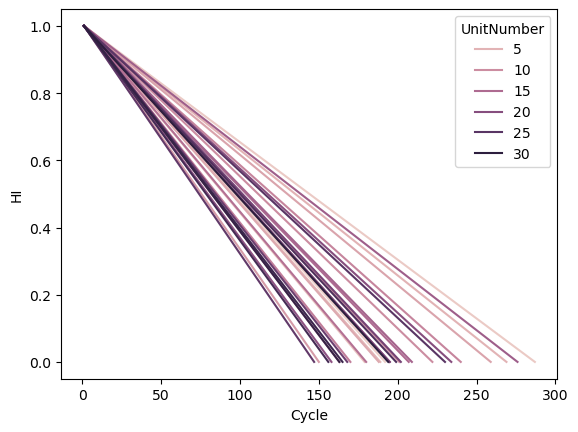

In [38]:
sns.lineplot(data= df_new[df_new.UnitNumber < 31], x = 'Cycle', y = 'HI', hue= 'UnitNumber')

In [39]:
model = LinearRegression()

In [40]:
X = df_new[feats]
y = df_new.HI
X.shape, y.shape

((20631, 14), (20631,))

In [41]:
model.fit(X,y)
model.score(X,y)

/Users/jinchan/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/jinchan/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

0.5314074565758771

In [42]:
model.coef_

array([-2.76560175,  2.71910461, -0.75702281, -0.79954961,  1.30952294,
       -0.13505797,  0.1822058 ,  0.95164787,  1.22813938,  0.58832133,
        1.18490907,  0.72212043, -1.35982571,  0.10941392])

In [43]:
len(model.coef_)

14

In [44]:
model.intercept_

-1.2694719381504826

In [45]:
df_new['HI_final'] = df_new[feats].dot(model.coef_)
df_new.HI_final.head()

0    1.784606
1    1.905034
2    2.041376
3    2.138887
4    2.191869
Name: HI_final, dtype: float64

In [46]:
df_new.HI_final

0        1.784606
1        1.905034
2        2.041376
3        2.138887
4        2.191869
           ...   
20626    1.352363
20627    1.401109
20628    1.456252
20629    1.519326
20630    1.588776
Name: HI_final, Length: 20631, dtype: float64

In [47]:
df_new

UnitNumber  SensorMeasure11  SensorMeasure12  SensorMeasure4  \
0             1.0         0.426373         0.554121        0.458215   
1             1.0         0.390723         0.585377        0.433588   
2             1.0         0.351107         0.620548        0.406529   
3             1.0         0.321811         0.646156        0.386070   
4             1.0         0.304281         0.661064        0.373110   
...           ...              ...              ...             ...   
20626       100.0         0.566898         0.437028        0.560573   
20627       100.0         0.550041         0.448259        0.547831   
20628       100.0         0.531108         0.463279        0.533634   
20629       100.0         0.509820         0.481143        0.517845   
20630       100.0         0.486406         0.502451        0.500548   

       SensorMeasure7  SensorMeasure15  SensorMeasure21  SensorMeasure20  \
0            0.543752         0.472216         0.542153         0.503353   
1            0.567716         0.448886         0.559857         0.525809   
2            0.593993         0.422287         0.578788         0.550543   
3            0.613922         0.403253         0.593750         0.569164   
4            0.626659         0.392282         0.604057         0.580923   
...               ...              ...              ...              ...   
20626        0.443494         0.556376         0.460902         0.410792   
20627        0.455767         0.552696         0.473380         0.421349   
20628        0.469627         0.542623         0.485396         0.433982   
20629        0.485178         0.529152         0.497977         0.448400   
20630        0.502415         0.510277         0.510479         0.464848   

       SensorMeasure13  SensorMeasure8  SensorMeasure2  SensorMeasure17  \
0             0.326241        0.312026        0.454180         0.439544   
1             0.320638        0.307248        0.442679         0.429688   
2             0.314824        0.302285        0.430545         0.419309   
3             0.309952        0.298135        0.420683         0.410857   
4             0.306104        0.294879        0.413411         0.404592   
...                ...             ...             ...              ...   
20626         0.355278        0.336611        0.509982         0.487763   
20627         0.351380        0.333247        0.501927         0.480871   
20628         0.346988        0.329529        0.493592         0.473654   
20629         0.342177        0.325478        0.484665         0.465903   
20630         0.336826        0.321024        0.475268         0.457682   

       SensorMeasure3  SensorMeasure9  SensorMeasure14  Cycle  RUL        HI  \
0            0.445774        0.164045         0.194727      1  191  1.000000   
1            0.439819        0.163916         0.194579      2  190  0.994764   
2            0.433520        0.163780         0.194424      3  189  0.989529   
3            0.428347        0.163663         0.194290      4  188  0.984293   
4            0.424456        0.163561         0.194176      5  187  0.979058   
...               ...             ...              ...    ...  ...       ...   
20626        0.474654        0.164740         0.195524    196    4  0.020101   
20627        0.470505        0.164675         0.195449    197    3  0.015075   
20628        0.466152        0.164570         0.195329    198    2  0.010050   
20629        0.461529        0.164448         0.195188    199    1  0.005025   
20630        0.456670        0.164292         0.195009    200    0  0.000000   

       HI_final  
0      1.784606  
1      1.905034  
2      2.041376  
3      2.138887  
4      2.191869  
...         ...  
20626  1.352363  
20627  1.401109  
20628  1.456252  
20629  1.519326  
20630  1.588776  

[20631 rows x 19 columns]

/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN be

Text(0, 0.5, 'Health Indicator')

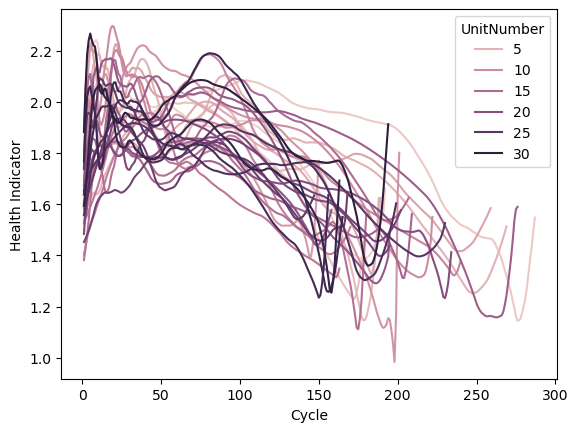

In [48]:
sns.lineplot(data= df_new[df_new.UnitNumber < 31], x = 'Cycle', y = 'HI_final', hue= 'UnitNumber')
plt.ylabel('Health Indicator')

/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values

Text(0, 0.5, 'Health Indicator')

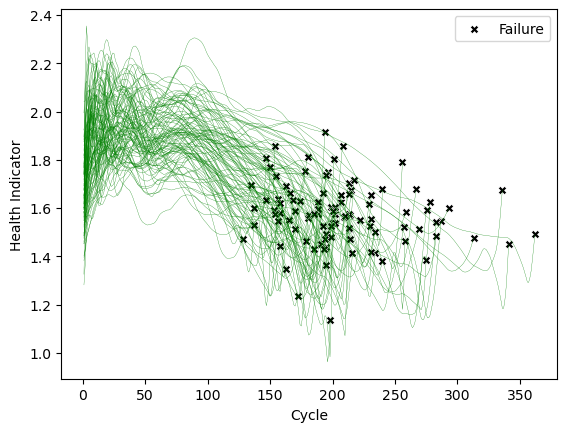

In [49]:
for i in range(1,101):
    sns.lineplot(data= df_new[df_new.UnitNumber == i], x = 'Cycle', y = 'HI_final', color = 'green', lw = 0.2)
sns.scatterplot(data = df_new[df_new.HI == 0], x = 'Cycle', y = 'HI_final', label = 'Failure',
                marker = 'X', color = 'black')
plt.ylabel('Health Indicator')

In [50]:
params_list = []
for i in range(1,101):
    y = df_new.HI_final[df_new.UnitNumber == i]
    cycle = df_new.Cycle[df_new.UnitNumber == i]
    theta_5, theta_4, theta_3, theta_2, theta_1, theta_0 = np.polyfit(cycle, y, 5)
    params_list.append({'UnitNumber':i, 'theta_0': theta_0, 'theta_1': theta_1, 'theta_2': theta_2, 'theta_3': theta_3, 'theta_4': theta_4, 'theta_5': theta_5})
params_df = pd.DataFrame(params_list, columns = ['UnitNumber', 'theta_5', 'theta_4', 'theta_3', 'theta_2', 'theta_1', 'theta_0'])

In [51]:
params_df.head()

UnitNumber       theta_5       theta_4       theta_3   theta_2   theta_1  \
0           1  1.411125e-10 -6.306192e-08  9.638134e-06 -0.000594  0.010730   
1           2  5.772853e-12 -3.546526e-09  6.711159e-07 -0.000053  0.002327   
2           3  1.136481e-10 -4.690953e-08  6.688367e-06 -0.000431  0.012345   
3           4  8.546786e-11 -4.142764e-08  7.241992e-06 -0.000603  0.024838   
4           5  1.916411e-11 -1.179227e-08  2.503806e-06 -0.000227  0.007119   

    theta_0  
0  2.047434  
1  1.963427  
2  1.849192  
3  1.491797  
4  1.987200

In [52]:
HI = df_new.HI_final[df_new.UnitNumber == 1]
cycle = df_new.Cycle[df_new.UnitNumber == 1]
theta_0 = params_df.theta_0[params_df.UnitNumber == 1].values
theta_1 = params_df.theta_1[params_df.UnitNumber == 1].values
theta_2 = params_df.theta_2[params_df.UnitNumber == 1].values
HI_fit = theta_0 + theta_1*cycle + theta_2*cycle*cycle + theta_3*cycle*cycle*cycle + theta_4*cycle*cycle*cycle*cycle + theta_5*cycle*cycle*cycle*cycle*cycle

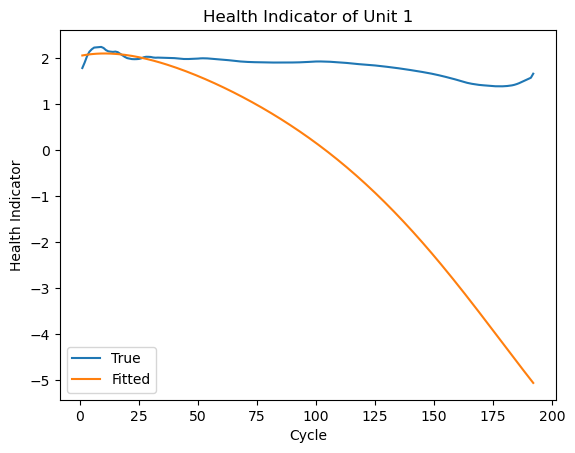

In [53]:
plt.plot(cycle,HI, label = 'True')
plt.plot(cycle,HI_fit, label = 'Fitted')
plt.ylabel('Health Indicator')
plt.xlabel('Cycle')
plt.legend()
plt.title('Health Indicator of Unit 1');

/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values

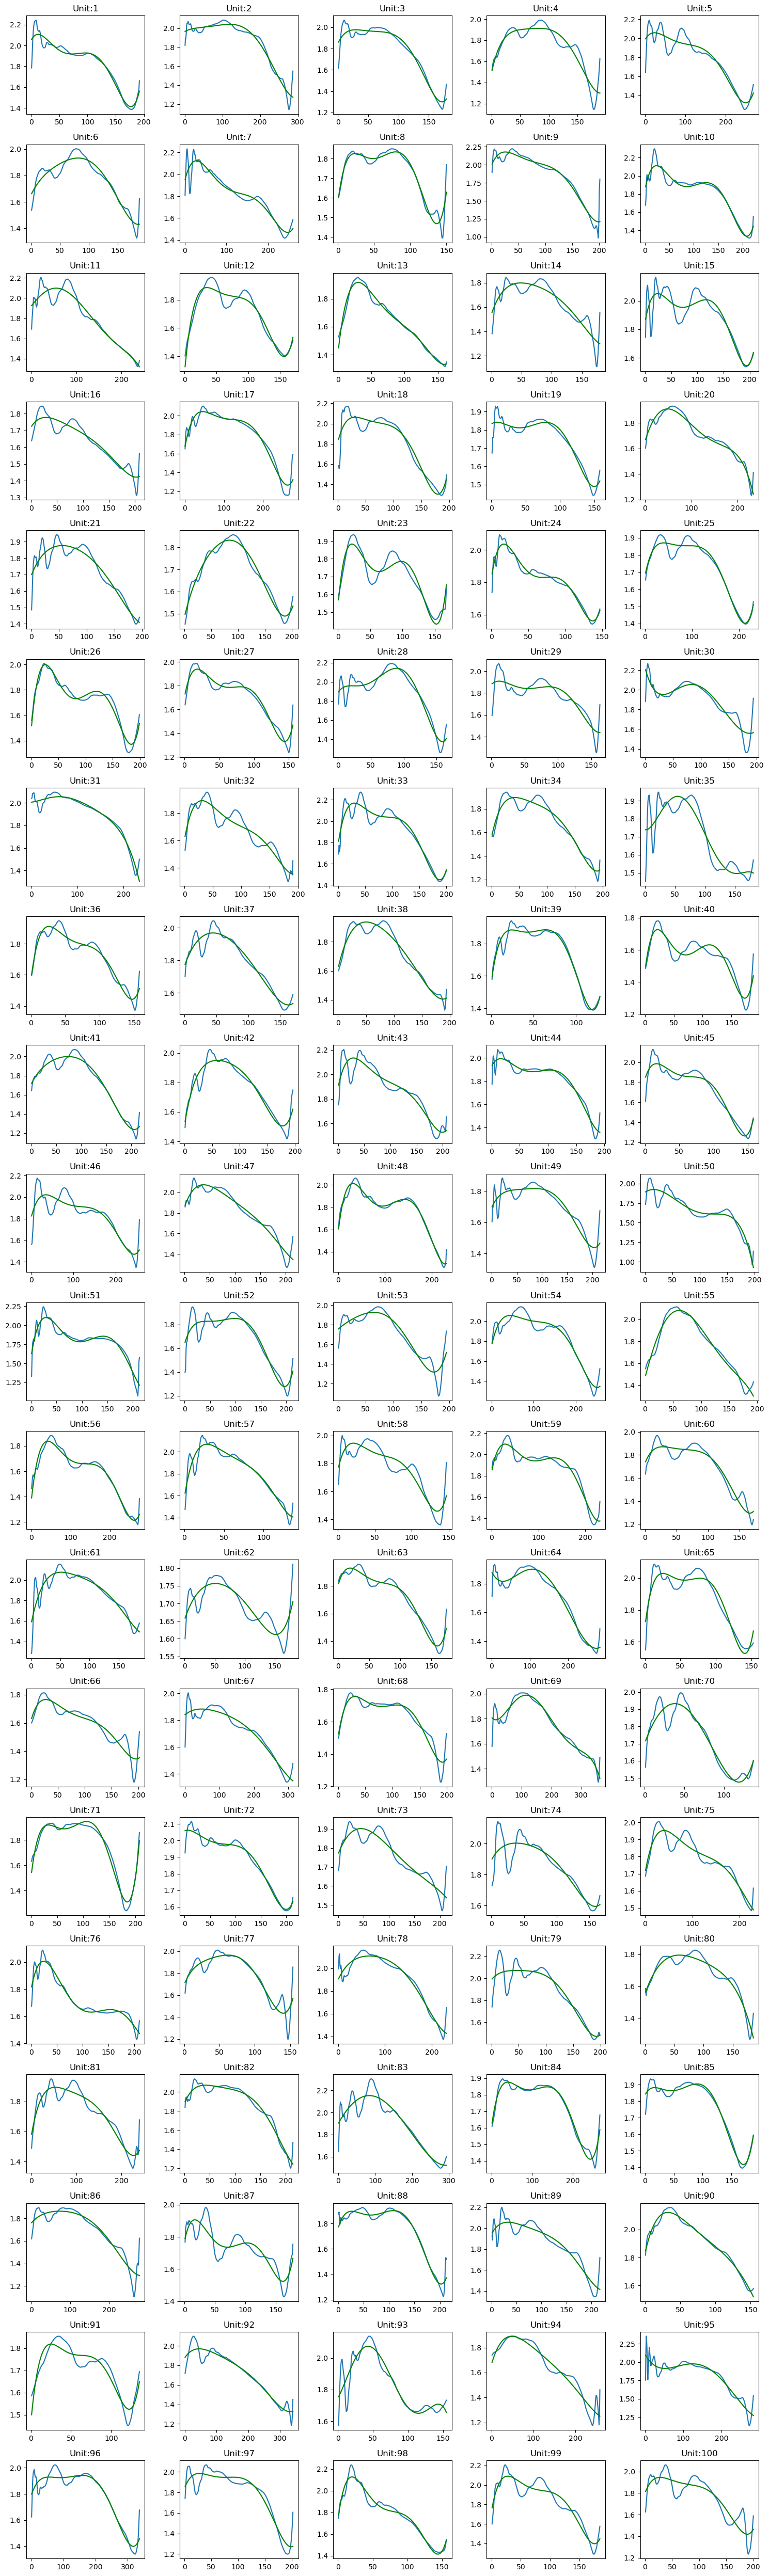

In [54]:
fig, ax = plt.subplots(nrows = 20, ncols = 5, figsize = (15,50))
ax = ax.ravel()
for i in range(0,100):
    theta_0 = params_df.theta_0[params_df.UnitNumber == i+1].values
    theta_1 = params_df.theta_1[params_df.UnitNumber == i+1].values
    theta_2 = params_df.theta_2[params_df.UnitNumber == i+1].values
    theta_3 = params_df.theta_3[params_df.UnitNumber == i+1].values
    theta_4 = params_df.theta_4[params_df.UnitNumber == i+1].values
    theta_5 = params_df.theta_5[params_df.UnitNumber == i+1].values
    cycle = df_new.Cycle[df_new.UnitNumber == i+1]
    fit_HI = theta_0 + theta_1*cycle + theta_2*cycle*cycle + theta_3*cycle*cycle*cycle + theta_4*cycle*cycle*cycle*cycle + theta_5*cycle*cycle*cycle*cycle*cycle
    sns.lineplot(data = df_new[df_new.UnitNumber == i+1], x = "Cycle", y = "HI_final", ax = ax[i])
    sns.lineplot(y = fit_HI, x = cycle, ax = ax[i], color = "green")
    ax[i].set_title("Unit:" + str(i+1))
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
plt.tight_layout()

In [55]:
dwt_test_list = []
for i in range(len(feats)):
    dwt = lowpassfilter(df_test[feats].iloc[:, i], 0.4)
    dwt_test_list.append(dwt)

In [56]:
df_test_dwt = pd.DataFrame(dwt_test_list)

In [57]:
df_test_dwt  = df_test_dwt.T

In [58]:
df_test_dwt

0         1         2         3         4         5         6   \
0      0.352927  0.628205  0.400028  0.608451  0.409172  0.587938  0.563672   
1      0.350207  0.627353  0.395158  0.607930  0.408231  0.587449  0.563088   
2      0.347458  0.626434  0.389819  0.607360  0.407298  0.586920  0.562459   
3      0.345129  0.625659  0.385870  0.606884  0.406501  0.586474  0.561929   
4      0.343245  0.625029  0.383646  0.606499  0.405849  0.586110  0.561500   
...         ...       ...       ...       ...       ...       ...       ...   
13091  0.365953  0.631951  0.415851  0.610675  0.413816  0.590077  0.566235   
13092  0.363706  0.631294  0.413027  0.610294  0.412998  0.589701  0.565785   
13093  0.361164  0.630588  0.410316  0.609880  0.412082  0.589298  0.565302   
13094  0.358247  0.629753  0.408278  0.609379  0.411052  0.588824  0.564732   
13095  0.355498  0.628954  0.404886  0.608900  0.410082  0.588368  0.564186   

             7         8         9         10        11        12        13  
0      0.279311  0.259041  0.398906  0.397079  0.382670  0.204130  0.243593  
1      0.279794  0.259526  0.390096  0.386872  0.380451  0.165484  0.206536  
2      0.280315  0.260048  0.380361  0.375295  0.378101  0.147265  0.186545  
3      0.280767  0.260503  0.373249  0.367129  0.376225  0.119190  0.159226  
4      0.281152  0.260892  0.369412  0.362923  0.374902  0.089719  0.132000  
...         ...       ...       ...       ...       ...       ...       ...  
13091  0.277189  0.256906  0.426214  0.428527  0.391651  0.345391  0.378249  
13092  0.277559  0.257277  0.421337  0.423999  0.390039  0.333915  0.366246  
13093  0.277959  0.257680  0.416760  0.418902  0.388371  0.319776  0.351770  
13094  0.278433  0.258158  0.413599  0.413554  0.386706  0.302609  0.334622  
13095  0.278886  0.258614  0.407724  0.406316  0.384810  0.264715  0.299137  

[13096 rows x 14 columns]

In [59]:
df_test_dwt.columns = feats

In [60]:
df_test_dwt

feature  SensorMeasure11  SensorMeasure12  SensorMeasure4  SensorMeasure7  \
0               0.352927         0.628205        0.400028        0.608451   
1               0.350207         0.627353        0.395158        0.607930   
2               0.347458         0.626434        0.389819        0.607360   
3               0.345129         0.625659        0.385870        0.606884   
4               0.343245         0.625029        0.383646        0.606499   
...                  ...              ...             ...             ...   
13091           0.365953         0.631951        0.415851        0.610675   
13092           0.363706         0.631294        0.413027        0.610294   
13093           0.361164         0.630588        0.410316        0.609880   
13094           0.358247         0.629753        0.408278        0.609379   
13095           0.355498         0.628954        0.404886        0.608900   

feature  SensorMeasure15  SensorMeasure21  SensorMeasure20  SensorMeasure13  \
0               0.409172         0.587938         0.563672         0.279311   
1               0.408231         0.587449         0.563088         0.279794   
2               0.407298         0.586920         0.562459         0.280315   
3               0.406501         0.586474         0.561929         0.280767   
4               0.405849         0.586110         0.561500         0.281152   
...                  ...              ...              ...              ...   
13091           0.413816         0.590077         0.566235         0.277189   
13092           0.412998         0.589701         0.565785         0.277559   
13093           0.412082         0.589298         0.565302         0.277959   
13094           0.411052         0.588824         0.564732         0.278433   
13095           0.410082         0.588368         0.564186         0.278886   

feature  SensorMeasure8  SensorMeasure2  SensorMeasure17  SensorMeasure3  \
0              0.259041        0.398906         0.397079        0.382670   
1              0.259526        0.390096         0.386872        0.380451   
2              0.260048        0.380361         0.375295        0.378101   
3              0.260503        0.373249         0.367129        0.376225   
4              0.260892        0.369412         0.362923        0.374902   
...                 ...             ...              ...             ...   
13091          0.256906        0.426214         0.428527        0.391651   
13092          0.257277        0.421337         0.423999        0.390039   
13093          0.257680        0.416760         0.418902        0.388371   
13094          0.258158        0.413599         0.413554        0.386706   
13095          0.258614        0.407724         0.406316        0.384810   

feature  SensorMeasure9  SensorMeasure14  
0              0.204130         0.243593  
1              0.165484         0.206536  
2              0.147265         0.186545  
3              0.119190         0.159226  
4              0.089719         0.132000  
...                 ...              ...  
13091          0.345391         0.378249  
13092          0.333915         0.366246  
13093          0.319776         0.351770  
13094          0.302609         0.334622  
13095          0.264715         0.299137  

[13096 rows x 14 columns]

In [61]:
df_test['HI'] = df_test_dwt.dot(model.coef_)
df_test.HI.head()

0    1.816436
1    1.855147
2    1.866066
3    1.893653
4    1.928002
Name: HI, dtype: float64

In [62]:
df_test

UnitNumber  Cycle  OpSet1  OpSet2  OpSet3  SensorMeasure1  \
0               1      1  0.0023  0.0003   100.0             0.0   
1               1      2 -0.0027 -0.0003   100.0             0.0   
2               1      3  0.0003  0.0001   100.0             0.0   
3               1      4  0.0042  0.0000   100.0             0.0   
4               1      5  0.0014  0.0000   100.0             0.0   
...           ...    ...     ...     ...     ...             ...   
13091         100    194  0.0049  0.0000   100.0             0.0   
13092         100    195 -0.0011 -0.0001   100.0             0.0   
13093         100    196 -0.0006 -0.0003   100.0             0.0   
13094         100    197 -0.0038  0.0001   100.0             0.0   
13095         100    198  0.0013  0.0003   100.0             0.0   

       SensorMeasure2  SensorMeasure3  SensorMeasure4  SensorMeasure5  ...  \
0            0.545181        0.310661        0.269413             0.0  ...   
1            0.150602        0.379551        0.222316             0.0  ...   
2            0.376506        0.346632        0.322248             0.0  ...   
3            0.370482        0.285154        0.408001             0.0  ...   
4            0.391566        0.352082        0.332039             0.0  ...   
...               ...             ...             ...             ...  ...   
13091        0.611446        0.619359        0.566172             0.0  ...   
13092        0.605422        0.537388        0.671843             0.0  ...   
13093        0.671687        0.482014        0.414754             0.0  ...   
13094        0.617470        0.522128        0.626435             0.0  ...   
13095        0.524096        0.666667        0.721472             0.0  ...   

       SensorMeasure13  SensorMeasure14  SensorMeasure15  SensorMeasure16  \
0             0.220588         0.132160         0.308965              0.0   
1             0.264706         0.204768         0.213159              0.0   
2             0.220588         0.155640         0.458638              0.0   
3             0.250000         0.170090         0.257022              0.0   
4             0.220588         0.152751         0.300885              0.0   
...                ...              ...              ...              ...   
13091         0.176471         0.584890         0.564063              0.0   
13092         0.308824         0.572350         0.485956              0.0   
13093         0.235294         0.605326         0.507888              0.0   
13094         0.294118         0.622046         0.562524              0.0   
13095         0.250000         0.591908         0.636399              0.0   

       SensorMeasure17  SensorMeasure18  SensorMeasure19  SensorMeasure20  \
0             0.333333              0.0              0.0         0.558140   
1             0.416667              0.0              0.0         0.682171   
2             0.416667              0.0              0.0         0.728682   
3             0.250000              0.0              0.0         0.666667   
4             0.166667              0.0              0.0         0.658915   
...                ...              ...              ...              ...   
13091         0.500000              0.0              0.0         0.395349   
13092         0.583333              0.0              0.0         0.333333   
13093         0.583333              0.0              0.0         0.372093   
13094         0.583333              0.0              0.0         0.403101   
13095         0.666667              0.0              0.0         0.434109   

       SensorMeasure21        HI  
0             0.661834  1.816436  
1             0.686827  1.855147  
2             0.721348  1.866066  
3             0.662110  1.893653  
4             0.716377  1.928002  
...                ...       ...  
13091         0.418669  1.660917  
13092         0.528721  1.672389  
13093         0.429301  1.687228  
13094         0.518779  1.706689  
13095         0.40

In [63]:
list_test_fit = []
for i in df_test.UnitNumber.unique():
    HI = df_test.HI[df_test.UnitNumber == i]
    cycle = df_test.Cycle[df_test.UnitNumber == i]
    for j in params_df.UnitNumber.unique():
        theta_0 = params_df.theta_0[params_df.UnitNumber == j].values
        theta_1 = params_df.theta_1[params_df.UnitNumber == j].values
        theta_2 = params_df.theta_2[params_df.UnitNumber == j].values
        theta_3 = params_df.theta_3[params_df.UnitNumber == j].values
        theta_4 = params_df.theta_4[params_df.UnitNumber == j].values
        theta_5 = params_df.theta_5[params_df.UnitNumber == j].values
        pred_HI = theta_0 + theta_1*cycle + theta_2*cycle*cycle + theta_3*cycle*cycle*cycle + theta_4*cycle*cycle*cycle*cycle + theta_5*cycle*cycle*cycle*cycle*cycle
        Residual = np.mean(np.abs(pred_HI - HI))
        total_life = df_train.Cycle[df_train.UnitNumber == j].max()
        similarity_score = np.exp(-Residual*Residual)
        list_test_fit.append({'UnitNumber':i, 'Model': j, 'Residual': Residual,
                              'similarity': similarity_score, 'total_life': total_life})
df_test_fit = pd.DataFrame(list_test_fit, columns=['UnitNumber', 'Model', 'Residual', 'similarity', 'total_life'])

In [64]:
df_test_fit.head()

UnitNumber  Model  Residual  similarity  total_life
0           1      1  0.172729    0.970605         192
1           1      2  0.075800    0.994271         287
2           1      3  0.043232    0.998133         179
3           1      4  0.175216    0.969766         189
4           1      5  0.130729    0.983055         269

In [65]:
ind_5 = df_test_fit.groupby('UnitNumber')['similarity'].nlargest(5).reset_index()['level_1']
result_df_5 = df_test_fit.iloc[ind_5]
result_df_5.head()

UnitNumber  Model  Residual  similarity  total_life
49           1     50  0.017376    0.999698         198
28           1     29  0.024001    0.999424         163
62           1     63  0.024800    0.999385         174
86           1     87  0.033625    0.998870         178
91           1     92  0.033839    0.998856         341

In [66]:
len(result_df_5)

500

/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values

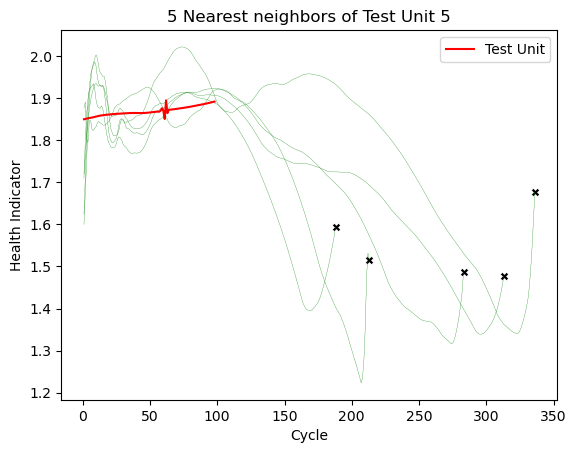

In [67]:
dff = result_df_5[result_df_5.UnitNumber == 3]

for i in dff.Model.unique():
    sns.lineplot(data= df_new[df_new.UnitNumber == i], x = 'Cycle', y = 'HI_final', color = 'green', lw = 0.2)
    sns.scatterplot(data = df_new[(df_new.UnitNumber == i) & (df_new.HI == 0)], x = 'Cycle', y = 'HI_final',
                    marker = 'X', color = 'black')

sns.lineplot(data= df_test[df_test.UnitNumber == 5], x = 'Cycle', y = 'HI', color = 'red',
             label = 'Test Unit')
plt.ylabel('Health Indicator')
plt.title('5 Nearest neighbors of Test Unit 5');

In [68]:
y_true_5 = y_true.copy()

y_true_5['Pred_RUL'] = (result_df_5.groupby('UnitNumber')['total_life'].mean() - df_test.groupby('UnitNumber')['Cycle'].max()).values
y_true_5.head()

RUL  UnitNumber  Pred_RUL
0  112           1     179.8
1   98           2     174.8
2   69           3     140.6
3   82           4     101.0
4   91           5     147.4

Text(0, 0.5, 'True RUL')

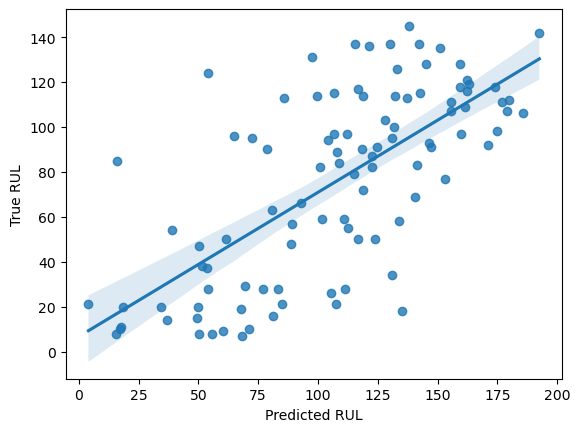

In [69]:
sns.regplot(x = y_true_5.Pred_RUL, y = y_true_5.RUL)
plt.xlabel('Predicted RUL')
plt.ylabel('True RUL')

/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values

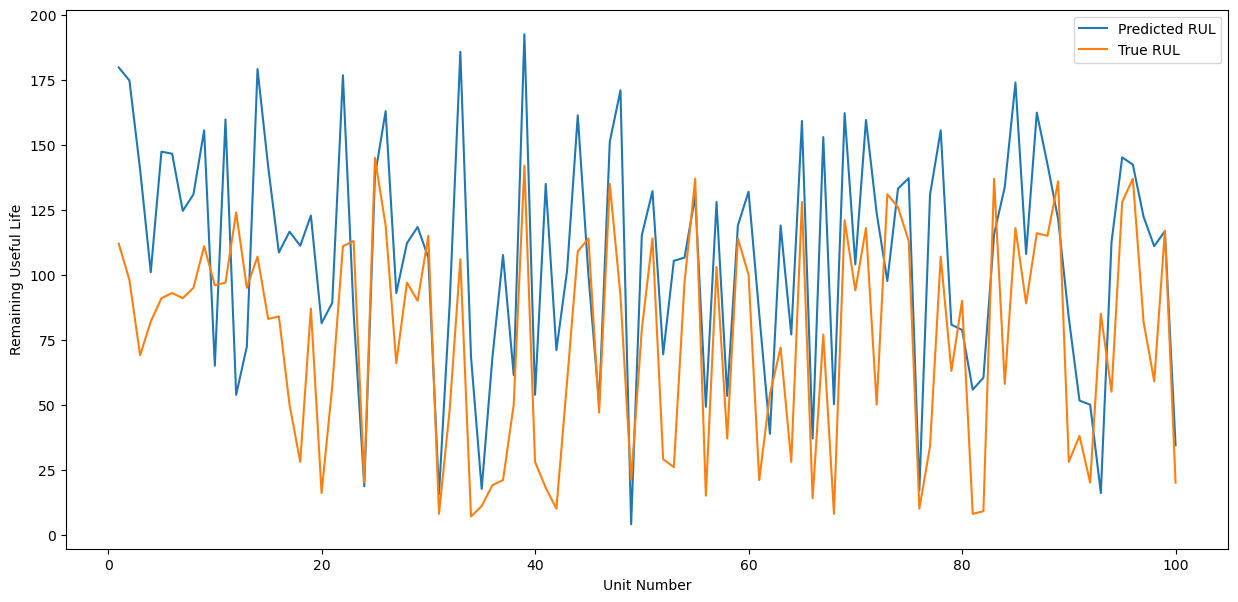

In [70]:
fig, ax = plt.subplots(figsize = (15, 7))
sns.lineplot(x = y_true_5.UnitNumber, y = y_true_5.Pred_RUL, label = "Predicted RUL")
sns.lineplot(x = y_true_5.UnitNumber, y = y_true_5.RUL, label = "True RUL")
plt.xlabel("Unit Number")
plt.ylabel("Remaining Useful Life")
plt.legend(loc = 1)

In [71]:
mean_squared_error(y_true_5.RUL, y_true_5.Pred_RUL)

/Users/jinchan/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_

2156.7408

In [72]:
mean_absolute_error(y_true_5.RUL, y_true_5.Pred_RUL)

/Users/jinchan/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_

39.104

In [73]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [74]:
mean_absolute_percentage_error(y_true_5.RUL, y_true_5.Pred_RUL)

108.20157747399941